In [1]:
#
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [49]:
# TODO: we don't need most of these libararies, so maybe do some culling?
#
import datetime as dtm
import matplotlib.dates as mpd
import pytz
tzutc = pytz.timezone('UTC')

#import operator
import math
import random
import numpy
import scipy
import scipy.optimize as spo
from scipy import interpolate
import itertools
import sys
#import scipy.optimize as spo
import os
import operator
#from PIL import Image as ipp
import multiprocessing as mpp
#
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import json
import pickle
#

import geopy.distance
#from geopy.distance import vincenty
#from geopy.distance import great_circle
#
#import shapely.geometry as sgp
os.environ['PROJ_LIB'] = '{}/anaconda3/share/proj'.format(os.getenv('HOME'))
#
from mpl_toolkits.basemap import Basemap as Basemap
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from geographiclib.geodesic import Geodesic as ggp
#

#import ANSStools as atp
from yodiipy import ANSStools as atp
#
import contours2kml
import globalETAS as gep

import global_etas_auto as ggep

from eq_params import *
#
from nepal_figs import *
import optimizers
#
import random
import geopy

In [50]:
# load up a couple of ETAS grids and subtract -- what's changed.
# TODO: SOON: interpolate onto a common grid (to start with, just assume they're identical)
# TODO: Add activations; normalization, etc., so we can maybe look at relative, spatial changes.
#
# TODO: revise naming scheme so we don't get these stupid names:
# ... yeah, these names are going to be a pain.
#xyz_path_1 = '{}/Dropbox/etas/Ridgecrest_July_2019/etas_2019-07-12 17/47/51.614362+00\/00/etas_Ridgecrest_July_2019_2019_07_2019-07-12_17/47/51.614362+00/00.xyz'
#xyz_path_1 = '{}/Dropbox/Research/etas/Ridgecrest_July_2019/data_temp/etas_Ridgecrest_July_2019_2019_07_2019-07-12_17-47-51.614362.xyz'.format(os.getenv('HOME'))
#
# /Users/myoder96
xyz_path_1 = '{}/Dropbox/Research/etas/Ridgecrest_July_2019/data_temp/etas_Ridgecrest_July_2019_2019_07_2019-07-09_03-11-27.728640.xyz'.format(os.getenv('HOME'))
xyz_path_2 = '{}/Dropbox/Research/etas/Ridgecrest_July_2019/data_temp/etas_Ridgecrest_July_2019_2019_07_2019-07-12_17-47-51.614362.xyz'.format(os.getenv('HOME'))
XYZ_1 = []
with open(xyz_path_1) as fin:
    for rw in fin:
        if rw.startswith('#'):
            print('** ', rw)
            continue
        XYZ_1 += [[float(x) for x in rw[:-1].split('\t')] ]
    #
#
XYZ_1 = numpy.array(XYZ_1)
#
XYZ_2 = []
with open(xyz_path_2) as fin:
    for rw in fin:
        if rw.startswith('#'):
            print('** ', rw)
            continue
        XYZ_2 += [[float(x) for x in rw[:-1].split('\t')] ]
    #
#
XYZ_2 = numpy.array(XYZ_2)

**  #globalETAS xyz (lon, lat, z_etas) export

**  #eventually, add metadata

**  #!x	\y	z

**  #globalETAS xyz (lon, lat, z_etas) export

**  #eventually, add metadata

**  #!x	\y	z



In [51]:
print(XYZ_1[0:4])

#
print('lens: {}, {}'.format(len(XYZ_1), len(XYZ_2)))
#

[[-1.19506000e+02  3.37050000e+01  6.16428241e-11]
 [-1.19406000e+02  3.37050000e+01  6.31923833e-11]
 [-1.19306000e+02  3.37050000e+01  6.47411277e-11]
 [-1.19206000e+02  3.37050000e+01  6.63306080e-11]]
lens: 1600, 1600


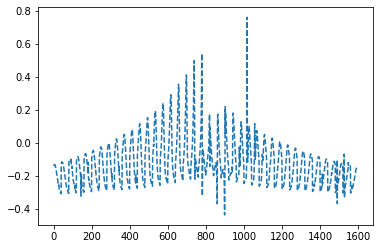

In [52]:
fg = plt.figure()
ax = plt.gca()
#
# ax.plot(XYZ_1[:,2])
# ax.plot(XYZ_2[:,2])
ax.plot((XYZ_2[:,2] - XYZ_1[:,2])/(XYZ_2[:,2] + XYZ_1[:,2]), ls='--')

In [53]:
#
# what is the fastest way to grid these data? That depends, I think, on a few things like -- can we assume
# they are all on the same grid? Is the list of elements complete? etc.
# I think just use scipy.interpolate.interp2d. Oh, and that way, it always works!
#
# new grid:
# lens of input extents:
n_x1, n_y2 = len(set(XYZ_1[:,0])), len(set(XYZ_1[:,1]))
n_x2, n_y2 = len(set(XYZ_1[:,0])), len(set(XYZ_1[:,1]))


print('lens: ', len(set(XYZ_1[:,0])), len(set(XYZ_1[:,1])) )
print('lens: ', len(set(XYZ_2[:,0])), len(set(XYZ_2[:,1])) )
sx, sy = len(set(XYZ_1[:,0])), len(set(XYZ_1[:,1]))
#
x_new = numpy

lens:  40 40
lens:  40 40


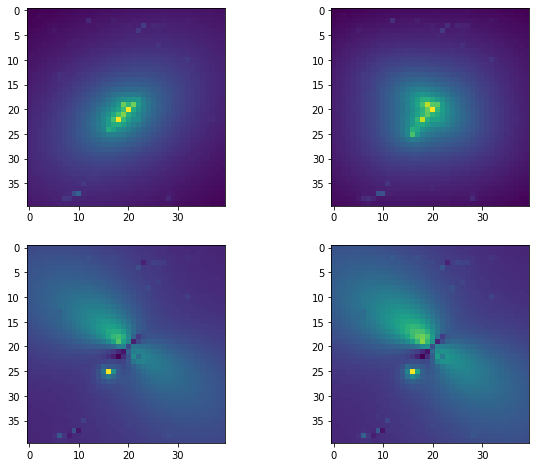

In [54]:
z1_2d = numpy.log(numpy.reshape(XYZ_1[:,2], (sy, sx)))
z2_2d = numpy.log(numpy.reshape(XYZ_2[:,2], (sy, sx)))
dz_rel = ((XYZ_2[:,2] - XYZ_1[:,2])/(XYZ_2[:,2] + XYZ_1[:,2])).reshape((sy, sx))
#
fg = plt.figure(figsize=(10,8))
ax1 = plt.subplot('221')
ax2 = plt.subplot('222')
ax3 = plt.subplot('223')
ax4 = plt.subplot('224')
#n
ax1.imshow(z1_2d)
ax2.imshow(z2_2d)
#
ax3.imshow( (z2_2d-z1_2d))
ax4.imshow(dz_rel)

In [55]:
# Now, let's look at some diffing with forecasting potential.
# RI/PI 2.0:
# - define a map area
# - We'll run nETAS in cumulative mode (counting expected cumulative number of earthquakes)
#    for t0 -> tf with a catalog spanning t0 -> t1, and computing N for t1 < t < tf
#   (aka forecasting the number of events in t1 < t <tf)
# - Then run the same scenario, but with the full catalog, complete t0 -> tf (consider even length catalogs,
#   in time or N for balance to account for the different catalog lengths. maybe lineraly scale?)
# - Subtract as a test.
#
# THEN:
#. introduce a third, earlier time domain, so we can predict and test.
#. - prediction domain: t1 < t < t2
#. - test time  domain:  t2 < t <tf
#
# for Ridgecrest, we are interested in the time following the m=6.4 event until a running "now", and
#. particularly up until right before the m=7.1 event... and then reconsile that with the variable
#. naming in globalETAS
#
# Something new:
#. - Use the first earthquake as the null model
#. - A sort of running PI...
#. - t0: reference start time
#. - t1: reference estimator time
#. - t2: prediction time (probaby "now")
#. - compute Cum-nETAS for t0 < t <t2 using the catalog for t0 < t <t1
#. - Compute what we've got: Cum-nETAS for t0 < t < t2
#. - subtract. is our early model predicting the current state? Are we producing more/fewer events than expected? where?
#
# timezone?
t0 = dtm.datetime(1990,1,1, 0,0,0)
t1 = t_m6
t2 = t_m7


NameError: name 't_m6' is not defined

In [56]:
### Ridgecrest nETAS parameters:
# event was some time on the 24th or maybe late the 23rd. this, plus defaults, should find the event:
#to_dt = dtm.datetime(2016,8,25, tzinfo=pytz.timezone('UTC'))
to_dt = dtm.datetime.now(pytz.timezone('UTC'))
#to_dt = dtm.datetime(2019,7,5,0,0,0, tzinfo=pytz.timezone('UTC'))
#
Lr_factor = 10.
# define these from the t_now in the actual etas object, in the event that we load it from pickle,
#  rather than calc it here.
#f_path = '/home/myoder/Dropbox/Research/etas/italy_2016_10/etas_{}'.format(to_dt)
#f_root = 'etas_2016'
#

t0 = dtm.datetime.now(pytz.timezone('UTC'))
t_ms = t0
#
# 
lat0 = 35.705
lon0 = -117.506
#
d_lat=2.
d_lon=2.
#
lats = [lat0-d_lat, lat0+d_lat]
lons = [lon0-d_lon, lon0+d_lon]
#to_dt = t0-dtm.timedelta(hours=2)
#to_dt = dtm.datetime.now(pytz.utc)
#
#etas = ggep.auto_etas(to_dt=to_dt, Lr_factor=Lr_factor, dt_0=5)
#italy_prams = {'do_recarray': True, 'D_fract': 1.5,
#                't_0':dtm.datetime(1990, 1, 1, 0, 0, tzinfo=pytz.timezone('UTC')),
#                't_now':to_dt, 
#                'lats': [42.,43.5], 'p': 1.1, 'b1': 1.0, 'mc': 2.5, 'q': 1.5,
#                'lons': [12.,15.], 'dmstar': 1.0, 'b2': 1.5, 'd_tau': 2.28,
#                'incat': None, 'fit_factor': 2.0, 'd_lambda': 1.76}
eq_prams = {'do_recarray': True, 'D_fract': 1.5,
               't_0':dtm.datetime(1990, 1, 1, 0, 0, tzinfo=pytz.timezone('UTC')),
               't_now':to_dt, 't_future':None ,
               'lats': lats, 'p_cat': 1.1, 'b1': 1.0, 'mc': 2.5, 'q_cat': 1.5,
               'p_etas':1.1, 'q_etas':1.5,
               'lons': lons, 'dmstar': 1.0, 'b2': 1.5, 'd_tau': 2.28,
               'incat': None, 'fit_factor': 2.0, 'd_lambda': 1.76, 'etas_range_padding':1.5,
            'etas_range_factor':30.0, 'ab_ratio_expon':.25 }
#eq_prams.update({'mc':3.0, 'd_lat':.25, 'd_lon':.25})

In [57]:
# Get a catalog. We've been having a bit of trouble with comcat -- I think mostly because it was just saturated,
#. but it does not hurt to. control it a bit here. Also, we can easily make sub-catalogs, etc.this way.
#
mycat = None
#
#mycat = atp.catfromANSS(lon=lons, lat=lats, minMag=2.5,
mycat = atp.cat_from_comcat(lon=lons, lat=lats, minMag=2.5,
                        dates0=[dtm.datetime(2005,1,1, tzinfo=pytz.timezone('UTC')), 
                                dtm.datetime.now(pytz.timezone('UTC'))],
                            Nmax=None, fout=None, rec_array=True)
#                        dates0=[dtm.datetime(2005,1,1, tzinfo=tzutc), None], Nmax=None, fout=None, rec_array=True)

mycat = gep.make_ETAS_catalog_mpp(incat=mycat, n_cpu=None)
#
# 

#
# mainshocks of interest:
# there is probably a one-step slicker way to do this, but for now...
ix = mycat['event_date']>dtm.datetime(2019,6,20)
mainshocks = (mycat[ix])[numpy.argsort( (mycat[ix])['mag'])[-2:]]
#
for ms in mainshocks:
    print('** ', ms)

etas_prams:  {'incat': None, 'lats': [32.0, 38.0], 'lons': [-117.0, -114.0], 'mc': 2.5, 'date_range': ['1990-1-1', None], 'D_fract': 1.5, 'd_lambda': 1.76, 'd_tau': 2.28, 'fit_factor': 1.5, 'p': 1.1, 'q': 1.5, 'dmstar': 1.0, 'b1': 1.0, 'b2': 1.5, 'do_recarray': False}
results fetched.
**  ('2019-07-04T17:33:49.040000', 35.7051667, -117.506, 6.4, 10.71, 737244.73181759, 27.54228703, 227.09312198, 0.00016708, 8.31763771, 25.27003406, 0.00911464, 1., 1.1, 1.5, 11.30220691, [0.01198123, 0.03287436], [[-0.73502555,  0.67803941], [-0.67803941, -0.73502555]], 1857.)
**  ('2019-07-06T03:19:53.040000', 35.7695, -117.5993333, 7.1, 8., 737246.13880833, 61.65950019, 1277.03847158, 1.40581446e-05, 18.62087137, 165.68091867, 0.00150686, 1., 1.1, 1.5, 26.80175629, [0.10043358, 0.06814984], [[ 0.86362798,  0.50412965], [-0.50412965,  0.86362798]], 2577.)


In [58]:
print('** ', mycat.dtype.names)

**  ('event_date', 'lat', 'lon', 'mag', 'depth', 'event_date_float', 'L_r', 'r_0', 'chi', 'dt_r', 't_0', 'tau', 'dmstar', 'p', 'q', 'chi_norm', 'e_vals', 'e_vecs', 'N_eig_cat')


In [74]:
# Compute some nETAS:
#
# will this work?
delta_t = (mainshocks[1]['event_date'].astype(dtm.datetime) - mainshocks[0]['event_date'].astype(dtm.datetime))/2.
print('** delta_t: ', delta_t)
# PI split time (as a float)
t_pi = mpd.date2num( mainshocks[0]['event_date'].astype(dtm.datetime) + delta_t )
t_final = mainshocks[1]['event_date'].astype(dtm.datetime) - dtm.timedelta(hours=1)
t_f_final = mpd.date2num(mainshocks[1]['event_date'].astype(dtm.datetime))
#
# predictor_etas:
eq_prams_predict = eq_prams.copy()
eq_prams_predict['t_now'] = mainshocks[0]['event_date'].astype(dtm.datetime) - dtm.timedelta(days=1)
eq_prams_predict['t_future'] = t_final
#
#cat_predict = mycat[mycat['event_date_float']<t_pi]
#
eq_prams_test = eq_prams.copy()
eq_prams_test['t_now'] = mainshocks[0]['event_date'].astype(dtm.datetime)- dtm.timedelta(days=1)
eq_prams_test['t_future'] = t_final

#
n_cpu = 2*mpp.cpu_count()
#n_cpu=5
etas_1 = gep.ETAS_mpp(n_cpu=n_cpu, catalog=mycat[mycat['event_date_float']<t_pi], **eq_prams_predict)
etas_2 = gep.ETAS_mpp(n_cpu=n_cpu, catalog=mycat[mycat['event_date_float']<t_f_final], **eq_prams_test)


#
#

** delta_t:  16:53:02
begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - catlen (3650.000000) = 2009-07-05 17:33:49.040000
ETAS over etas_cat_range/xyz_range:  ([0, 3708], None)
make_etas():
etas_mpp worker xyz_range:  [0, 100]
begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - catlen (3650.000000) = 2009-07-05 17:33:49.040000
ETAS over etas_cat_range/xyz_range:  ([0, 3708], [0, 100])
etas_mpp worker xyz_range:  [100, 200]
begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - catlen (3650.000000) = 2009-07-05 17:33:49.040000
ETAS over etas_cat_range/xyz_range:  ([0, 3708], [100, 200])
etas_mpp worker xyz_range:  [200, 300]
begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now

etas complete (from mpp_rtree run() loop); now pipe back([0, 3708])
finished calculateing ETAS (rtree). wrap up in recarray and return.
etas complete (from mpp_rtree run() loop); now pipe back([0, 3708])
finished calculateing ETAS (rtree). wrap up in recarray and return.
etas complete (from mpp_rtree run() loop); now pipe back([0, 3708])
ETAS complete.
begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - catlen (3650.000000) = 2009-07-05 17:33:49.040000
ETAS over etas_cat_range/xyz_range:  ([0, 3774], None)
make_etas():
etas_mpp worker xyz_range:  [0, 100]
begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - catlen (3650.000000) = 2009-07-05 17:33:49.040000
ETAS over etas_cat_range/xyz_range:  ([0, 3774], [0, 100])
etas_mpp worker xyz_range:  [100, 200]
begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for 

finished calculateing ETAS (rtree). wrap up in recarray and return.
etas complete (from mpp_rtree run() loop); now pipe back([0, 3774])
finished calculateing ETAS (rtree). wrap up in recarray and return.
etas complete (from mpp_rtree run() loop); now pipe back([0, 3774])
finished calculateing ETAS (rtree). wrap up in recarray and return.
etas complete (from mpp_rtree run() loop); now pipe back([0, 3774])
finished calculateing ETAS (rtree). wrap up in recarray and return.
etas complete (from mpp_rtree run() loop); now pipe back([0, 3774])
finished calculateing ETAS (rtree). wrap up in recarray and return.
etas complete (from mpp_rtree run() loop); now pipe back([0, 3774])
ETAS complete.


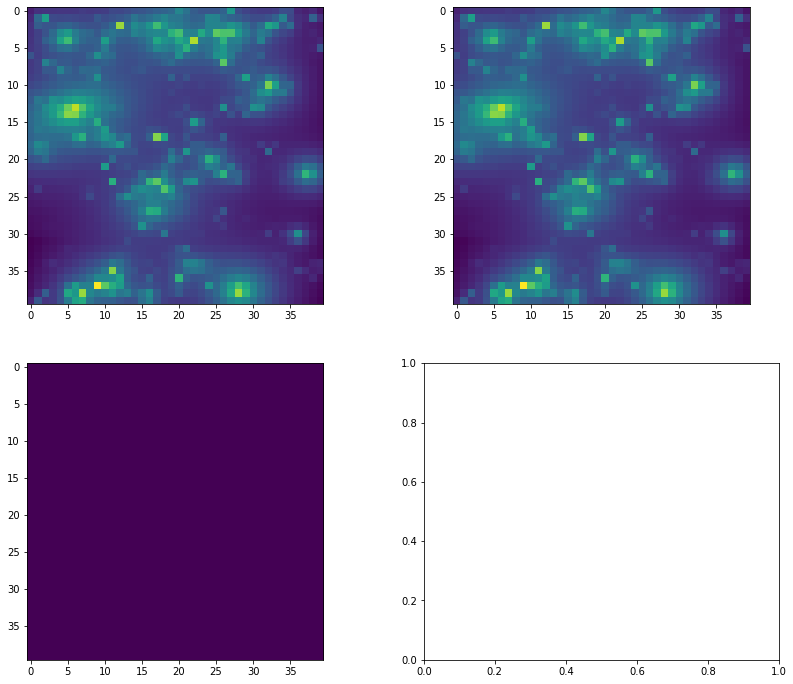

In [75]:
fg = plt.figure(figsize=(14,12))
#
ax1 = plt.subplot('221')
ax2 = plt.subplot('222')
ax3 = plt.subplot('223')
ax4 = plt.subplot('224')
#
#ax1.imshow(etas_1.`)
#etas_1.ETAS_array.shape
n,m = len(set(etas_1.ETAS_array['x'])), len(set(etas_1.ETAS_array['y']))
Zs_1 = numpy.log(etas_1.ETAS_array['z'])
Zs_2 = numpy.log(etas_2.ETAS_array['z'])
#
ax1.imshow(Zs_1.reshape((m,n)))
ax2.imshow(Zs_2.reshape((m,n)))
#
ax3.imshow((Zs_2-Zs_1).reshape((m,n)))

/Users/myoder96/Codes/globalETAS/globalETAS.py:339: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  
/Users/myoder96/Codes/globalETAS/globalETAS.py:343: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  #
/Users/myoder96/Codes/globalETAS/globalETAS.py:344: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  #map_cmap = map_cmap or self.map_cmap
/Users/myoder96/Codes/globalETAS/globalETAS.py:345: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if map_cmap is None: map_cmap = self.cmap_contours


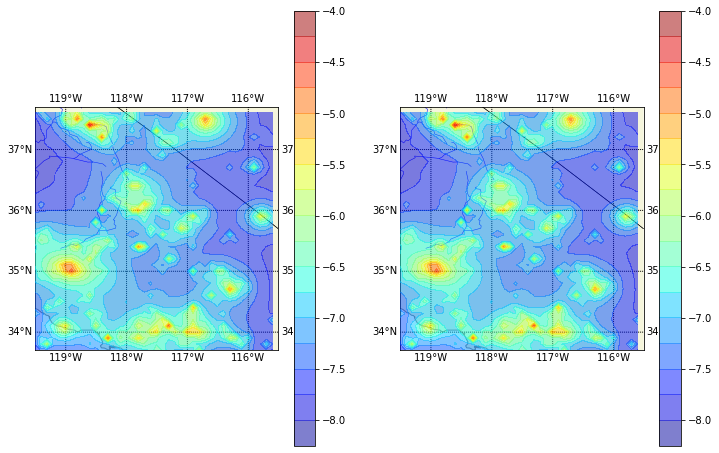

In [76]:
fg = plt.figure(figsize=(12,8))
ax1 = plt.subplot('121')
ax2 = plt.subplot('122')
etas_1.make_etas_contour_map(ax=ax1)
etas_2.make_etas_contour_map(ax=ax2)

### A Breief Distraction: Series of Cubic Sums
- Consider the sequence of numbers, $z = a^3 + b^3 + c^3$, where $a,b,c$ and therefore $z$ are integers
- The mystery is, what numbers are members of this sequence, $k \in z$ ?
- If a member, how many solutions are there?
- This was a Numberphile video. Then another Numberphile video.
- In those videos, we learn a few things:
  - 33 was a mystery for a long time
  - But then somebody found it. Now, "42 is the new 33"
  - 1 has an infinite number of solutions
  - There are a couple of small numbers that can be shown analytically to not exist in the series
  - A few other simple ones are on the line, but composed of HUGE sums (note $a,b,c$ can be negative)
  

In [68]:
#
# a quick distraction:
# see the Numberphiles on z = a^3 + b^3 + c^3
#
# write a quick script to find some of these numbers:
# A = numpy.arange(-200, 200)
# B = numpy.arange(-200, 200)
# C = numpy.arange(-200, 200)
#
#Zs = {}
# actuall, combinations() would be faster, right?
#for a,b,c in itertools.product(A,B,C):
# ABC = numpy.array(list(itertools.product(A,B,C)))
#Z = numpy.sum(ABC**3, axis=1)
#
# later, get the components too:
# NOTE: This is a more efficient way to get the cubic components, which does not suffer the artifact
#  of repeated sets in different order (aka, [abc, cba, ...]). the _with_replacement allows repeaded members
#  in each set, ie [[aaa, aab, abc, ...], ...].
#Zs = numpy.array(numpy.unique(numpy.sum(ABC**3, axis=1), return_counts=True)).T
numpy.array(numpy.unique(numpy.sum(numpy.array(list(itertools.combinations_with_replacement(numpy.arange(-200,200),3)))**3, axis=1),
                               return_counts=True)).T


array([[-24000000,         1],
       [-23880599,         1],
       [-23762392,         1],
       ...,
       [ 23406571,         1],
       [ 23523590,         1],
       [ 23641797,         1]])

In [69]:
# Zs2 = numpy.array(numpy.unique(numpy.sum(numpy.array(list(itertools.combinations_with_replacement(numpy.arange(-100,100),3)))**3, axis=1),
#                                return_counts=True)).T


NameError: name 'Zs' is not defined

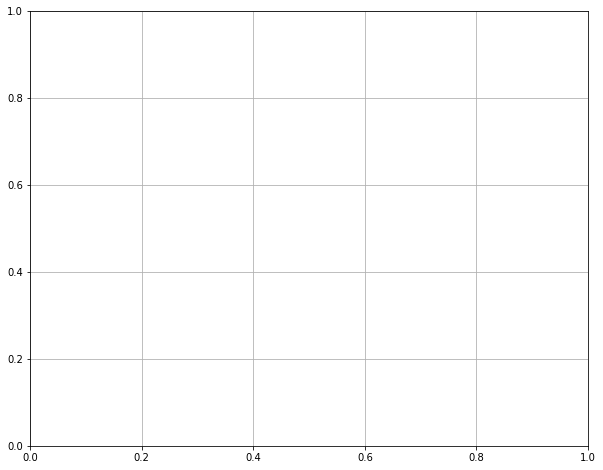

In [22]:
fg = plt.figure(figsize=(10,8))
ax1 = plt.gca()
ax1.grid()
#ax1.set_yscale('log')
#
ax1.plot(*Zs.T, ls='', marker='.')
#ax1.plot(*Zs2.T, ls='', marker='.')

In [ ]:
excluded_ks = [k for k in numpy.arange(min(Zs[:,0]), max(Zs[:,0]))if k not in Zs[:,0] ]
#
print('len x_ks: ', len(excluded_ks))